In [1]:
import os
import json
import copy

# List result Files
experiment_files = [a for a in os.listdir("./out") if ".json" in a]

# Load result Files
all_experiments = []
for filename in experiment_files:
    with open("./out/{}".format(filename), "r") as f:
        all_experiments.append(json.load(f))

# Aglomerate similar results
unique_experiment_names = list(dict.fromkeys([a["model"] for a in all_experiments]))
print(unique_experiment_names)

sorted_experiments = {}
for e in unique_experiment_names:
    sorted_experiments[e] = []

for e in all_experiments:
    sorted_experiments[e['model']].append(e)

['assine2022B_24', 'assine2022B_22', 'dummy', 'lee2021_layer_7', 'matsubara2022_4', 'matsubara2022_5', 'assine2022B_11', 'matsubara2022_2', 'assine2022B_14', 'lee2021_layer_10', 'lee2021_layer_5', 'assine2022B_33', 'assine2022B_34', 'matsubara2022_3', 'assine2022B_44']


In [2]:
baseline = sorted_experiments['dummy']

total_energy = sum([b['joules1'] for b in baseline])
total_seconds = sum([b['seconds'] for b in baseline])
baseline_power = total_energy/total_seconds
print(baseline_power)

2.902840984272222


In [3]:
aggregated_experiments = []

for exp_name, exp_list in sorted_experiments.items():
    joules = sum([e['joules1'] for e in exp_list])
    seconds = sum([e['seconds'] for e in exp_list])
    corrected_joules = joules - baseline_power*seconds
    num_images = sum([e['num_images'] for e in exp_list])
    aggregated_experiments.append({
        "joules": joules,
        "seconds": seconds,
        "corrected_joules": joules - baseline_power*seconds,
        "corrected_watts": (joules - baseline_power*seconds)/seconds,
        "corrected_joules_per_image": corrected_joules / num_images,
        "inference_time": seconds / num_images,
        "num_images": num_images,
        "model": exp_name,
        "macs(MMAC)": exp_list[0]['macs']/1e6,
        "bw(KB)": exp_list[0]['bw']/1e3,
        "map": exp_list[0]['map'],
        "params": exp_list[0]['params'],
    })
    
with open("test.json", "w+") as f:
    json.dump(aggregated_experiments, f)

In [4]:
import pandas as pd
df = pd.read_json('test.json')
df = df.set_index("model")
df = df.sort_index(ascending=True)
print(df)
df_back = copy.copy(df)

                      joules  seconds  corrected_joules  corrected_watts  \
model                                                                      
assine2022B_11    459.503767      120        111.162849         0.926357   
assine2022B_14    459.334337      120        110.993419         0.924945   
assine2022B_22    690.232012      180        167.720634         0.931781   
assine2022B_24    462.348745      120        114.007827         0.950065   
assine2022B_33    698.168086      180        175.656709         0.975871   
assine2022B_34    460.917466      120        112.576548         0.938138   
assine2022B_44    230.146255       60         55.975796         0.932930   
dummy             522.511377      180          0.000000         0.000000   
lee2021_layer_10  463.562153      120        115.221235         0.960177   
lee2021_layer_5   229.440291       60         55.269831         0.921164   
lee2021_layer_7   461.328328      120        112.987410         0.941562   
matsubara202

In [5]:
print(df[df.index.str.contains("matsubara")])
# print(df["matsubara" in df.index.str])__contains__("matsubara")

                     joules  seconds  corrected_joules  corrected_watts  \
model                                                                     
matsubara2022_2  475.701831      120        127.360913         1.061341   
matsubara2022_3  235.119665       60         60.949206         1.015820   
matsubara2022_4  716.236410      180        193.725033         1.076250   
matsubara2022_5  476.885545      120        128.544627         1.071205   

                 corrected_joules_per_image  inference_time  num_images  \
model                                                                     
matsubara2022_2                    1.959399        1.846154          65   
matsubara2022_3                    1.966103        1.935484          31   
matsubara2022_4                    2.017969        1.875000          96   
matsubara2022_5                    2.073300        1.935484          62   

                  macs(MMAC)  bw(KB)   map  params  
model                                        

In [6]:
print(df.to_latex()) 

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &      joules &  seconds &  corrected\_joules &  corrected\_watts &  corrected\_joules\_per\_image &  inference\_time &  num\_images &   macs(MMAC) &  bw(KB) &   map &   params \\
model            &             &          &                   &                  &                             &                 &             &              &         &       &          \\
\midrule
assine2022B\_11   &  459.503767 &      120 &        111.162849 &         0.926357 &                    0.156347 &        0.168776 &         711 &    75.690495 &   6.912 &  14.5 &    25332 \\
assine2022B\_14   &  459.334337 &      120 &        110.993419 &         0.924945 &                    0.148785 &        0.160858 &         746 &    75.690495 &  27.648 &  34.3 &    25332 \\
assine2022B\_22   &  690.232012 &      180 &        167.720634 &         0.931781 &                    0.245206 &        0.263158 &         684 &   151.380990 &  13.824 &  29.4 &    25332 \\
assine

/tmp/ipykernel_1656/3246126283.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


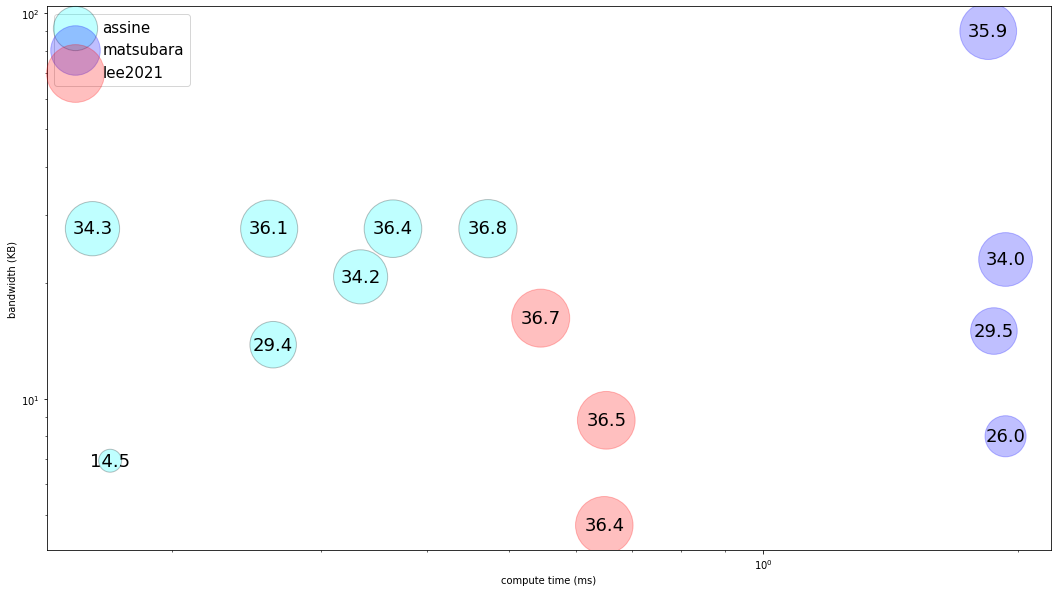

In [7]:
import matplotlib
font = {'family' : 'normal', 'size'   : 22}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt

df = copy.copy(df_back)
###########################################################################
def plot(ax, name, color='blue', configurable=False):
    a = df[df.index.str.contains(name)]
    bw = a['bw(KB)'].values
    latency = a['inference_time'].values
    mAP = a['map'].values
    
    z = 2.5*(mAP**2)
    z_label = ["{:2.1f}".format(m) for m in mAP]
    if configurable:
         ax.scatter(latency, bw, s=z, marker='o', color=color, alpha=0.25, label=name, edgecolor='black')
    else:
        ax.scatter(latency, bw, s=z, marker='o', color=color, alpha=0.25, label=name)
    for i in range(len(mAP)):
        ax.annotate(z_label[i], ( latency[i], bw[i]), ha='center', va='center', fontsize=18, color='black')



fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
ax.set_xlabel('compute time (ms)')
ax.set_ylabel('bandwidth (KB)')
ax.set_xscale('log')
ax.set_yscale('log')

f = "literature_comparison/literature.csv"
df.columns = df.columns.str.replace(' ', '')
plot(ax, "assine", color='cyan', configurable=True)
plot(ax, "matsubara", color='blue')
plot(ax, "lee2021", color='red')
# plot("assine", color='black',  configurable=True)

# bb = t.get_bbox_patch()
# bb.set_boxstyle("rarrow", pad=0.6)

# bbox_props = dict(boxstyle="rarrow", fc=(0.7, 0.1, 0.1), ec="b", lw=0)
# t = ax.text(520, 1e1, "Inverse Tradeoff", ha="center", va="center", rotation=-66,
#             size=18,
#             bbox=bbox_props)

# bbox_props = dict(boxstyle="larrow", fc=(0.1, 0.1, 0.7), ec="b", lw=0)
# t = ax.text(210, 9, "Direct Tradeoff", ha="center", va="center", rotation=40,
#             size=18,
#             bbox=bbox_props)


ax.legend(fontsize=15)
# plt.savefig(os.path.join("./out", "graph_sota.pdf"))
plt.show()
